In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from scipy.signal import detrend
import json

In [3]:
def shift_with_edge_pad(x, shift):
    if shift > 0:
        pad = np.full(shift, x[0])
        return np.concatenate([pad, x[:-shift]])
    elif shift < 0:
        pad = np.full(-shift, x[-1])
        return np.concatenate([x[-shift:], pad])
    else:
        return x

In [4]:
folder = './Dataset/Open/Edited_nonplant_split/train'
shift_amount_sec = 1.0
segment_len_sec = 3.0

normal_segments = []
segment_labels = []

for file in os.listdir(folder):
    if file.endswith('.wav'):
        wav_path = os.path.join(folder, file)
        txt_path = os.path.join(folder, file.replace('.wav', '-events.txt'))
        if not os.path.exists(txt_path):
            continue

        sr, data = wavfile.read(wav_path)
        if data.ndim > 1:
            data = data[:, 0]
        data = detrend(data)
        data_norm = (data - np.mean(data)) / np.std(data)
        seg_len = int(segment_len_sec * sr)

        # --- Parse all (1,2) marker pairs ---
        markers = []
        with open(txt_path, 'r') as f:
            for line in f:
                if line.strip() and line[0].isdigit():
                    m_id, m_time = line.split(',')
                    markers.append((int(m_id.strip()), float(m_time.strip())))

        # Make ordered list of anomaly regions (sample indices)
        anomaly_regions = []
        temp_start = None
        for m_id, m_time in markers:
            if m_id == 1:
                temp_start = int(m_time * sr)
            elif m_id == 2 and temp_start is not None:
                temp_end = int(m_time * sr)
                anomaly_regions.append((temp_start, temp_end))
                temp_start = None

        # If no valid anomaly region, treat entire file as normal
        if not anomaly_regions:
            normal_regions = [(0, len(data_norm))]
        else:
            # Compute the normal (non-anomaly) regions
            normal_regions = []
            last_end = 0
            for start, end in anomaly_regions:
                if last_end < start:
                    normal_regions.append((last_end, start))
                last_end = end
            if last_end < len(data_norm):
                normal_regions.append((last_end, len(data_norm)))

        # --- Extract non-anomaly segments from original signal ---
        for n_start, n_end in normal_regions:
            # Only full segments
            for i in range(n_start, n_end - seg_len + 1, seg_len):
                normal_segments.append(data_norm[i:i + seg_len])
                segment_labels.append(0)

        # --- Augmentation ---
        max_shift = int(shift_amount_sec * sr)
        shift_amount = random.randint(-max_shift, max_shift)
        data_shifted = shift_with_edge_pad(data_norm, shift_amount)

        # Shift all region indices
        anomaly_regions_shifted = []
        for start, end in anomaly_regions:
            s = max(0, min(len(data_shifted)-1, start + shift_amount))
            e = max(0, min(len(data_shifted)-1, end + shift_amount))
            anomaly_regions_shifted.append((s, e))
        # Compute normal regions for shifted
        if not anomaly_regions_shifted:
            normal_regions_shifted = [(0, len(data_shifted))]
        else:
            normal_regions_shifted = []
            last_end = 0
            for start, end in anomaly_regions_shifted:
                if last_end < start:
                    normal_regions_shifted.append((last_end, start))
                last_end = end
            if last_end < len(data_shifted):
                normal_regions_shifted.append((last_end, len(data_shifted)))
        # Extract non-anomaly segments from shifted
        for n_start, n_end in normal_regions_shifted:
            for i in range(n_start, n_end - seg_len + 1, seg_len):
                normal_segments.append(data_shifted[i:i + seg_len])
                segment_labels.append(1)

normal_segments = np.array(normal_segments, dtype=np.float32)
segment_labels = np.array(segment_labels, dtype=np.int32)
print("Total normal (non-anomaly) segments:", len(normal_segments))
print("Original (non-augmented):", np.sum(segment_labels == 0))
print("Augmented (shifted):", np.sum(segment_labels == 1))

Total normal (non-anomaly) segments: 1837
Original (non-augmented): 919
Augmented (shifted): 918


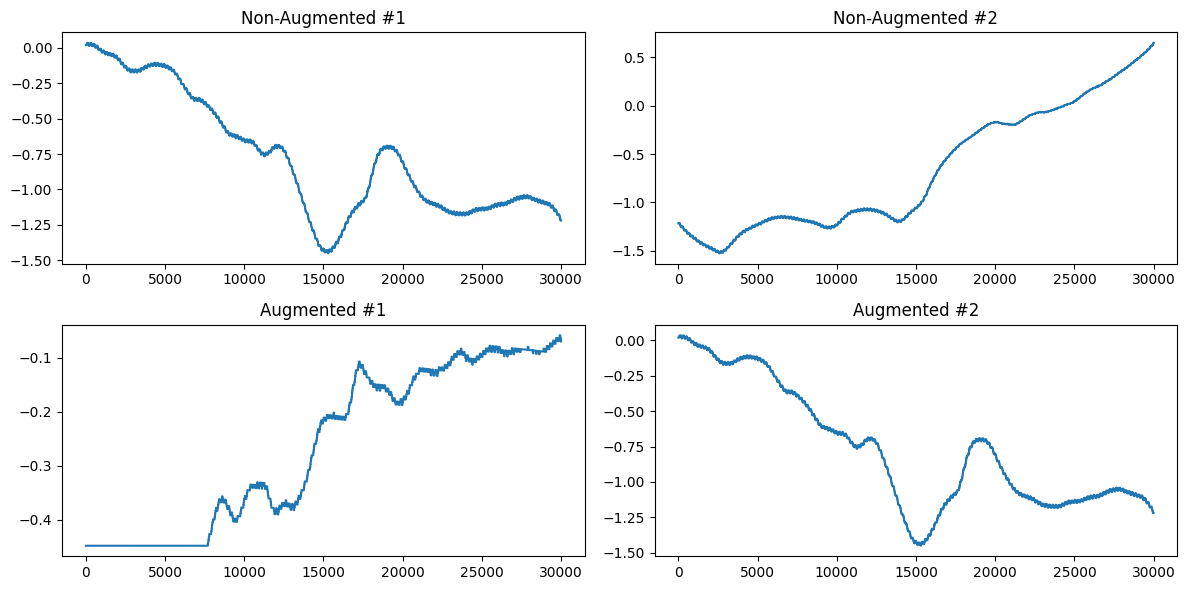

In [5]:
n_non_aug = np.where(segment_labels == 0)[0]
n_aug = np.where(segment_labels == 1)[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(n_non_aug[:2]):
    plt.subplot(2, 2, i + 1)
    plt.plot(normal_segments[idx])
    plt.title("Non-Augmented #%d" % (i + 1))
for i, idx in enumerate(n_aug[:2]):
    plt.subplot(2, 2, i + 3)
    plt.plot(normal_segments[idx])
    plt.title("Augmented #%d" % (i + 1))
plt.tight_layout()
plt.show()

Defining Class & Network Structure

In [6]:
class AudioSegDataset(Dataset):
    def __init__(self, segments):
        self.data = torch.from_numpy(segments)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]

dataset = AudioSegDataset(normal_segments)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, n),
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
n = normal_segments.shape[1]
model = Autoencoder(n)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

Training

In [ ]:
epochs = 500
loss_history = []
best_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 20
save_path = './Dataset/Open/Model/autoencoder/MAE/nonplant.pth'

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        batch_x = batch_x.float()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        epochs_no_improve = 0
        print("  Loss improved, model saved.")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

print(f"Best loss: {best_loss:.4f}")

with torch.no_grad():
    train_errors = []
    for batch_x, _ in dataloader:
        batch_x = batch_x.float()
        out = model(batch_x)
        errs = torch.mean((out - batch_x)**2, dim=1).cpu().numpy()
        train_errors.extend(errs)
train_errors = np.array(train_errors)
threshold = np.mean(train_errors) + 3 * np.std(train_errors)
print(f"Anomaly threshold: {threshold:.6f}")

with open('./Dataset/Open/Model/autoencoder/MAE/nonplant.json', 'w') as f:
    json.dump({'threshold': float(threshold)}, f)

Evaluation & Inference

Loaded threshold: 1.086368203163147
[test] BYB_Recording_2022-11-23_15.03.21.wav | IoU: 0.000 | Success: False


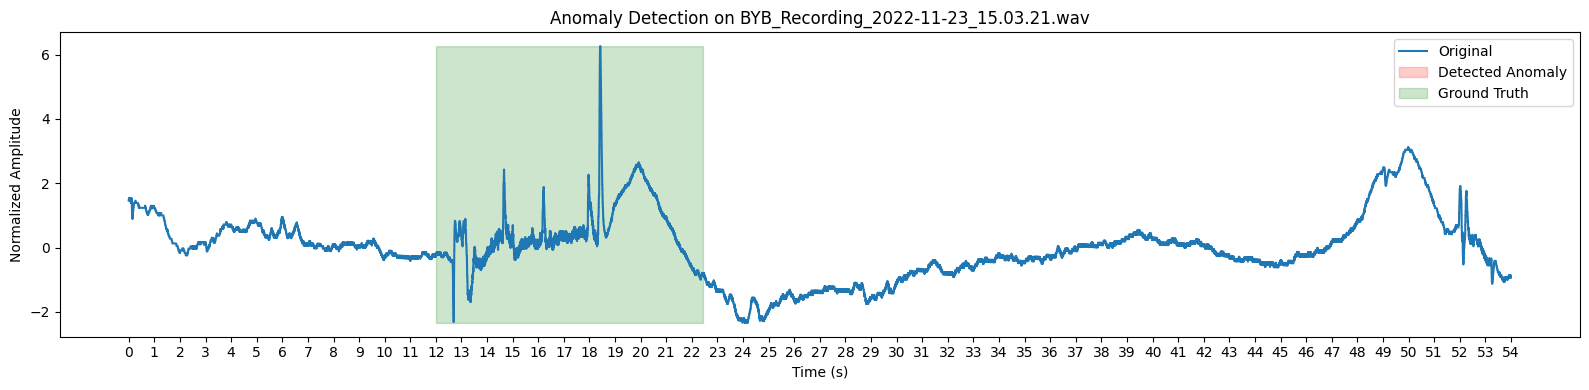

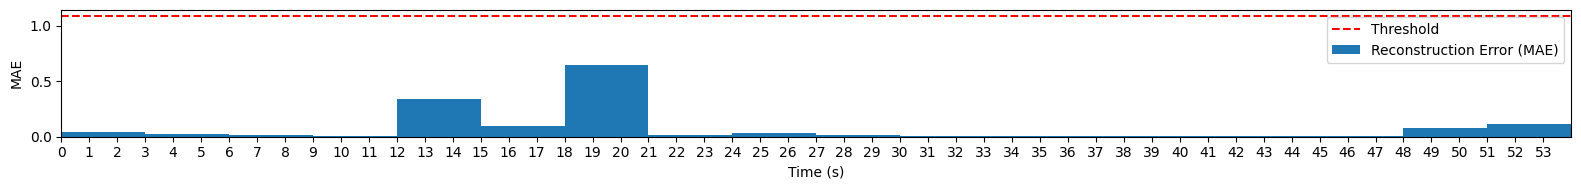

[test] BYB_Recording_2022-11-23_15.06.43.wav | IoU: 0.310 | Success: False


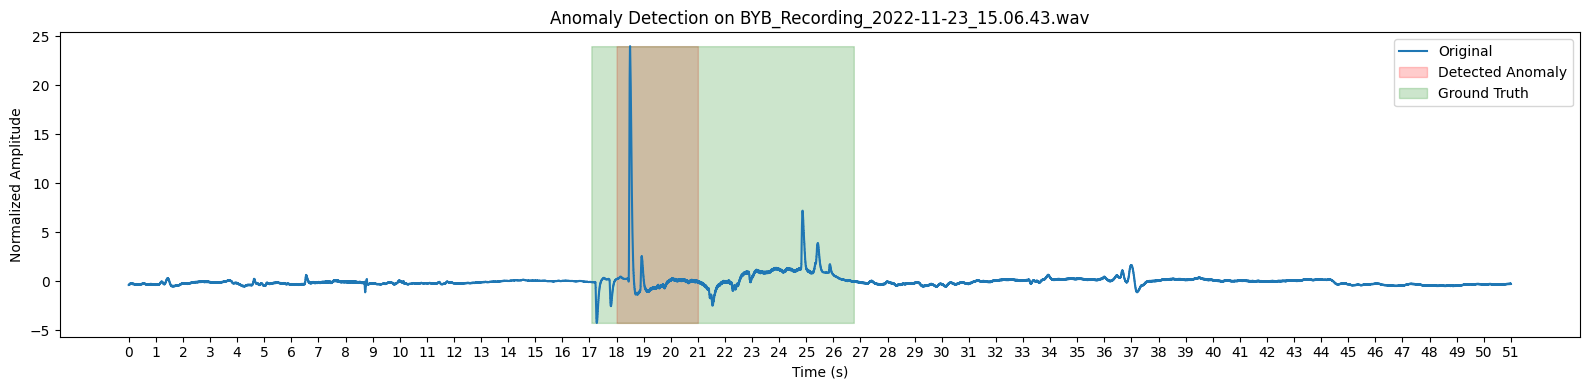

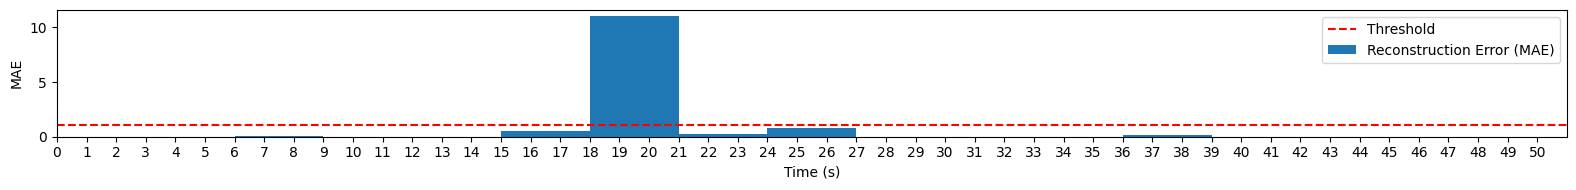

[test] BYB_Recording_2022-11-23_15.31.45.wav | IoU: 0.000 | Success: False


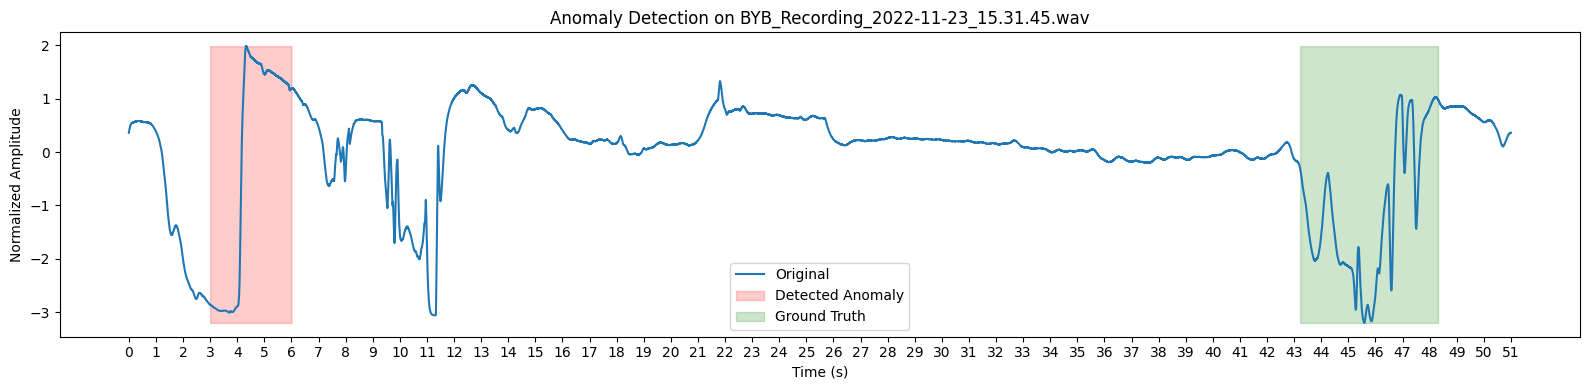

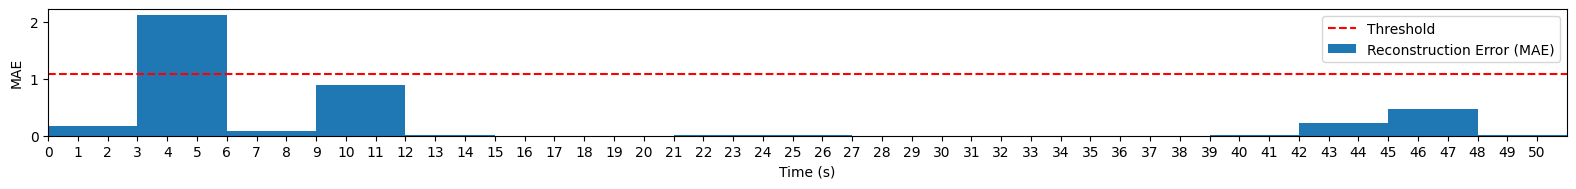

[test] BYB_Recording_2023-01-19_14.59.35.wav | IoU: 0.566 | Success: True


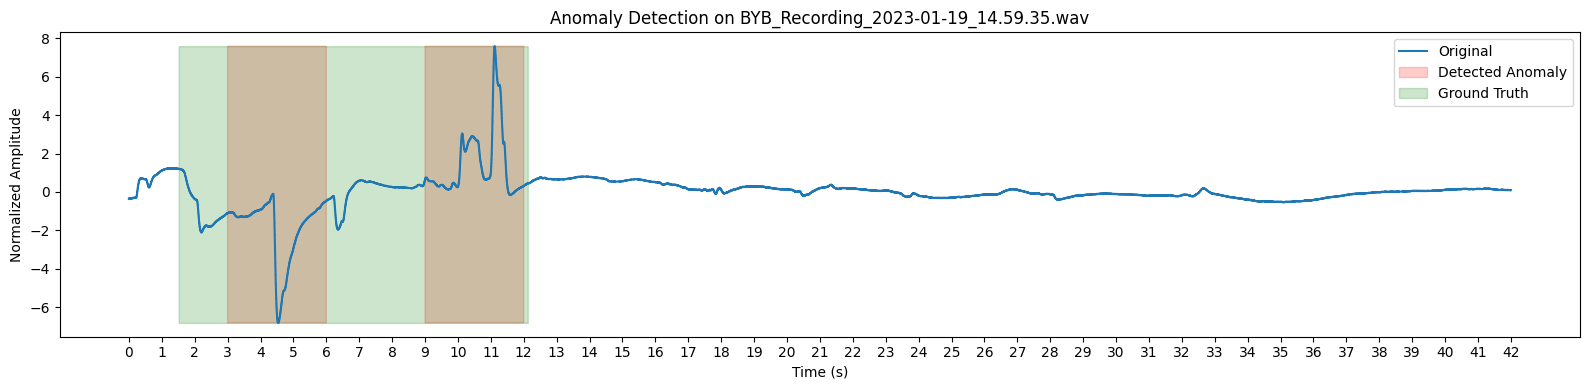

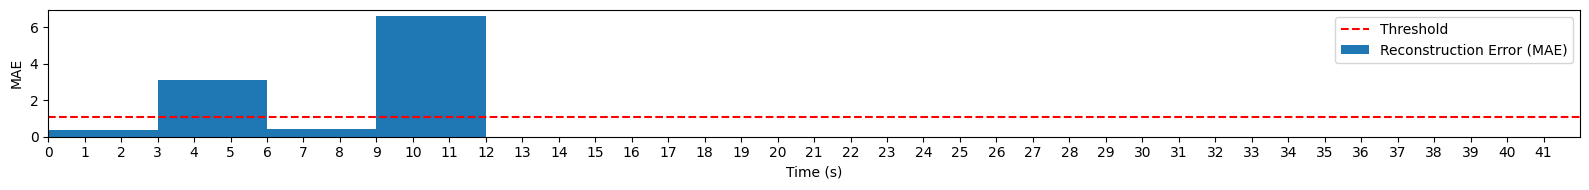

[test] BYB_Recording_2023-02-06_21.28.51.wav | IoU: 0.246 | Success: False


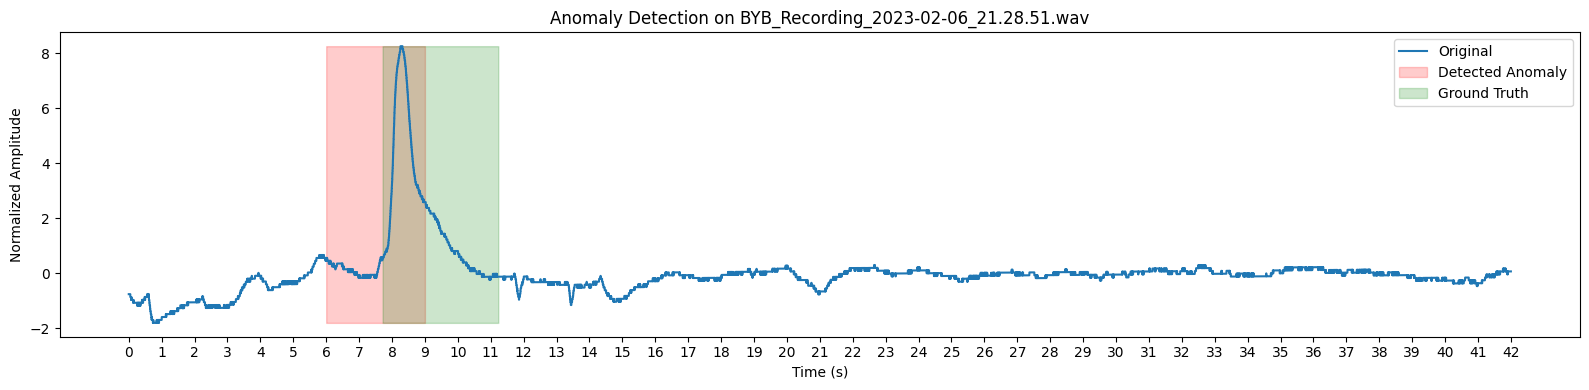

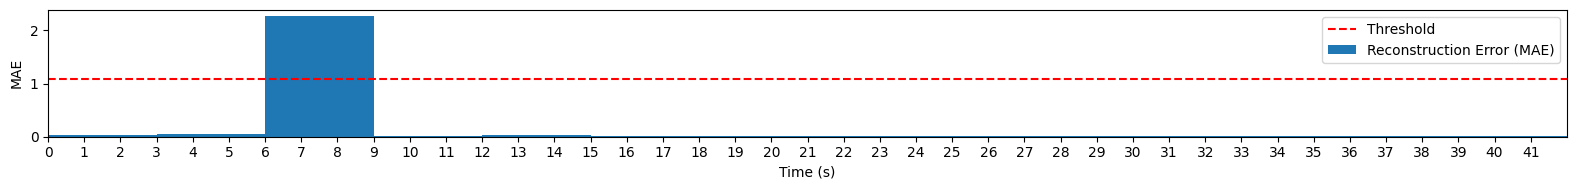

[test] Munich Mimosa_1 Stimulus Tap BYB_Recording_2022-09-15_10.31.03.wav | IoU: 0.000 | Success: False


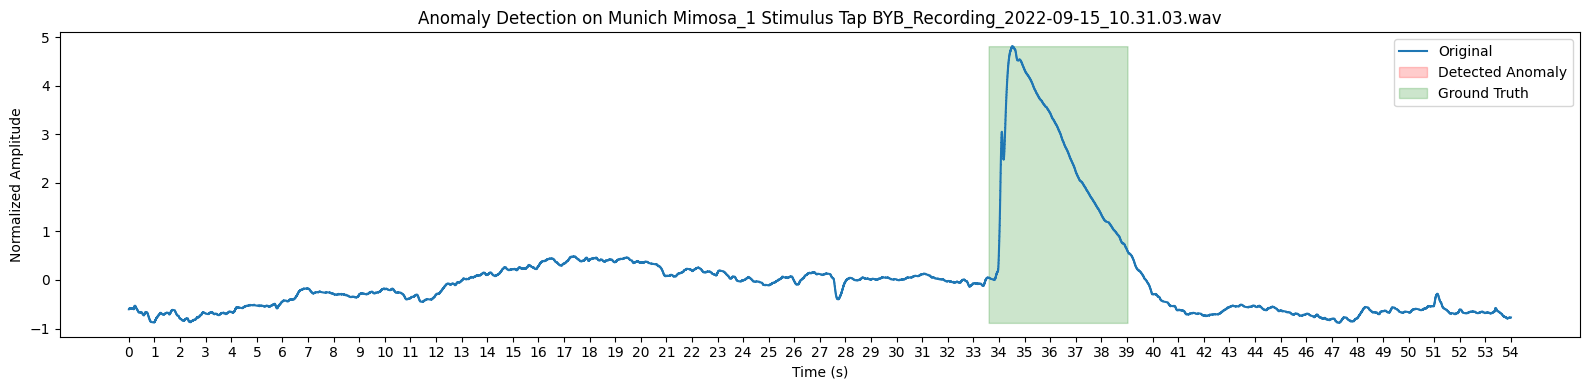

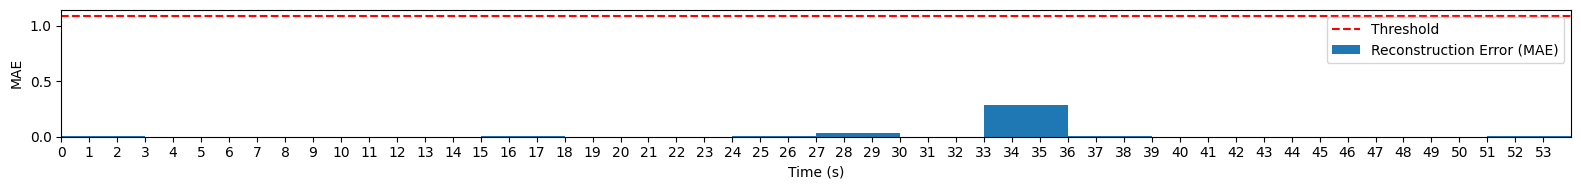

No files found for train.

Average IoU for test: 0.187
Success Rate (IoU >= 0.5) for test: 16.7%

Average IoU (Test & Train): 0.187
Overall Success Rate (IoU >= 0.5): 16.7%


In [10]:
load_path = './Dataset/Open/Model/autoencoder/MAE/nonplant.pth'
with open('./Dataset/Open/Model/autoencoder/MAE/nonplant.json', 'r') as f:
    threshold = json.load(f)['threshold']
print(f"Loaded threshold: {threshold}")

model = Autoencoder(n)
model.load_state_dict(torch.load(load_path))
model.eval()

splits = [
    # ('train', './Dataset/Open/Edited_nonplant_split/train'),
    ('test', './Dataset/Open/unseen/test')
]

split_ious = {'train': [], 'test': []}
split_success = {'train': [], 'test': []}

success_threshold = 0.5  # Set IoU threshold for successful detection

for split_name, folder in splits:
    wav_files = [file for file in os.listdir(folder) if file.endswith('.wav')]
    for wav_file in wav_files:
        txt_file = wav_file.replace('.wav', '-events.txt')
        txt_path = os.path.join(folder, txt_file)
        wav_path = os.path.join(folder, wav_file)
        if not os.path.exists(txt_path):
            print(f"Skipping {wav_file} (no marker file found).")
            continue

        # Load and preprocess
        sr, data = wavfile.read(wav_path)
        if data.ndim > 1:
            data = data[:, 0]
        data = detrend(data)
        data_norm = (data - np.mean(data)) / np.std(data)

        # Load marker (ground truth anomaly region)
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        markers = {}
        for line in lines:
            if line.strip() and line[0].isdigit():
                m_id, m_time = line.split(',')
                markers[int(m_id.strip())] = float(m_time.strip())
        if 1 not in markers or 2 not in markers:
            print(f"Skipping {wav_file} (invalid marker file).")
            continue
        start_sample = int(markers[1] * sr)
        end_sample = int(markers[2] * sr)

        # Segment the signal
        seg_len = int(segment_len_sec * sr)
        n_segments = len(data_norm) // seg_len
        trimmed = data_norm[:n_segments*seg_len]
        segments = trimmed.reshape(n_segments, seg_len)
        t = np.arange(len(trimmed)) / sr

        # Autoencoder reconstruction
        with torch.no_grad():
            input_tensor = torch.from_numpy(segments).float()
            recon = model(input_tensor).numpy()
        recon_full = recon.flatten()

        # Compute error and anomaly detection
        recon_errors = np.mean((segments - recon)**2, axis=1)
        is_anomaly = recon_errors > threshold
        anomaly_mask = np.zeros(len(trimmed), dtype=bool)
        for i, flag in enumerate(is_anomaly):
            if flag:
                anomaly_mask[i*seg_len:(i+1)*seg_len] = True

        # Ground truth mask
        gt_mask = np.zeros(len(trimmed), dtype=bool)
        start_sample = max(0, min(len(trimmed)-1, start_sample))
        end_sample = max(0, min(len(trimmed)-1, end_sample))
        gt_mask[start_sample:end_sample] = True

        intersection = np.sum(anomaly_mask & gt_mask)
        union = np.sum(anomaly_mask | gt_mask)
        iou = intersection / (union + 1e-8)
        split_ious[split_name].append(iou)

        # Mark as successful detection if IoU > threshold
        is_success = iou >= success_threshold
        split_success[split_name].append(is_success)
        print(f"[{split_name}] {wav_file} | IoU: {iou:.3f} | Success: {is_success}")

        # Plotting Signal
        plt.figure(figsize=(16,4))
        plt.plot(t, trimmed, label='Original')
        plt.fill_between(t, trimmed.min(), trimmed.max(), where=anomaly_mask, color='red', alpha=0.2, label='Detected Anomaly')
        plt.fill_between(t, trimmed.min(), trimmed.max(), where=gt_mask, color='green', alpha=0.2, label='Ground Truth')

        duration_sec = t[-1] if len(t) > 0 else 0
        plt.xticks(np.arange(0, duration_sec + 1, 1))

        plt.title(f'Anomaly Detection on {wav_file}')
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Amplitude')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plotting Error
        plt.figure(figsize=(16,2))
        x_seconds = np.arange(n_segments) * segment_len_sec
        
        # This is the new line that plots the actual error
        plt.bar(x_seconds, recon_errors, width=segment_len_sec, align='edge', label='Reconstruction Error (MAE)')
        
        plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
        plt.xlabel('Time (s)')
        plt.ylabel('MAE')
        plt.legend()
        plt.tight_layout()

        # Set x-ticks and limits to align with the plot above
        plt.xticks(np.arange(0, duration_sec + 1, 1))
        plt.xlim(t[0], t[-1])
        plt.show()

# Summarize per split
for split_name in split_ious:
    if len(split_ious[split_name]) > 0:
        avg_iou = np.mean(split_ious[split_name])
        success_rate = np.mean(split_success[split_name])
        print(f"\nAverage IoU for {split_name}: {avg_iou:.3f}")
        print(f"Success Rate (IoU >= {success_threshold}) for {split_name}: {success_rate*100:.1f}%")
    else:
        print(f"No files found for {split_name}.")

# Combine all IoUs and success flags for overall average
all_ious = split_ious['train'] + split_ious['test']
all_success = split_success['train'] + split_success['test']
if len(all_ious) > 0:
    overall_avg_iou = np.mean(all_ious)
    overall_success_rate = np.mean(all_success)
    print(f"\nAverage IoU (Test & Train): {overall_avg_iou:.3f}")
    print(f"Overall Success Rate (IoU >= {success_threshold}): {overall_success_rate*100:.1f}%")
else:
    print("No IoU values to combine.")